# Vibrational strong coupling of liquid water in a Bragg resonator: Unix socket

**Authors: Xinwei Ji, Tao E. Li**

Here, we introduce how to use MaxwellLink to run classical molecular dynamics (LAMMPS) simulations of liquid water under vibrational strong coupling by connecting MEEP FDTD with LAMMPS.

## 1. Run with realistic Bragg resonator

Let's try to setup a realistic Bragg resonator.

In [1]:
import numpy as np
import maxwelllink as mxl
import meep as mp

address = "socket_meep_lammps_vsc"
hub = mxl.SocketHub(unixsocket=address, timeout=10.0, latency=1e-5)

resolution = 20
time_units_fs = 20
rescaling = 0.47
pmlThickness = 2.0 * rescaling
t1 = 0.125 * rescaling
t2 = 0.25 * rescaling
n1 = 2.0
n2 = 1.0

nlayer = 20

layerIndexes = np.array([n2, n1] * nlayer + [1.0] + [n1, n2] * nlayer)
layerThicknesses = np.array([t2, t1] * nlayer + [0.5 * rescaling] + [t1, t2] * nlayer)


layerThicknesses[0] += pmlThickness
layerThicknesses[-1] += pmlThickness
length = np.sum(layerThicknesses)
layerCenters = np.cumsum(layerThicknesses) - layerThicknesses/2
layerCenters = layerCenters - length/2
cellSize = mp.Vector3(length, 0, 0)
pmlLayers = [mp.PML(thickness=pmlThickness)]
# we check energy conservation by removing PML layers
# pmlLayers = []

geometry = [mp.Block(mp.Vector3(layerThicknesses[i], mp.inf, mp.inf),
    center=mp.Vector3(layerCenters[i], 0, 0), material=mp.Medium(index=layerIndexes[i]))
    for i in range(layerThicknesses.size)]

molecule = mxl.Molecule(
    hub=hub,
    center=mp.Vector3(0, 0, 0), 
    size=mp.Vector3(0.25, 0, 0), 
    sigma=0.05, 
    dimensions=1, 
    rescaling_factor=1e5
)

sources_non_molecule = []
sources = sources_non_molecule + molecule.sources
sim = mxl.MeepSimulation(
    hub=hub,
    molecules=[molecule],
    cell_size=cellSize,
    resolution=resolution,
    time_units_fs=time_units_fs,
    sources=sources,
    geometry=geometry,
    boundary_layers=pmlLayers
)


Using MPI version 4.1, 1 processes
[Init Molecule] Under socket mode, registered molecule with ID 0


 ######### MaxwellLink Units Helper #########
 MEEP uses its own units system, which is based on the speed of light in vacuum (c=1), 
 the permittivity of free space (epsilon_0=1), and the permeability of free space (mu_0=1). 
 To couple MEEP with molecular dynamics, we set [c] = [epsilon_0] = [mu_0] = [hbar] = 1. 
 By further defining the time unit as 2.00E+01 fs, we can fix the units system of MEEP (mu).

 Given the simulation resolution = 20,
 - FDTD dt = 2.50E-02 mu (0.5/resolution) = 5.00E-01 fs
 - FDTD dx = 5.00E-02 mu (1.0/resolution) = 3.00E+02 nm
 - Time [t]: 1 mu = 2.00E+01 fs = 8.27E+02 a.u.
 - Length [x]: 1 mu = 6.00E+03 nm
 - Angular frequency [omega = 2 pi * f]: 1 mu = 3.2925E-02 eV = 2.6556E+02 cm-1 = 1.2100E-03 a.u.
 - Electric field [E]: 1 mu = 1.66E+03 V/m = 3.23E-09 a.u.
 Hope this helps!
 ############################################




## 2. Python way to lunch LAMMPS on a separate terminal

Generally, using the Socket Interface requires to launch the EM simulation in one terminal and then start the molecular driver simulation in a separate terminal. To avoid openning a second terminal, below we introduce a python helper function `launch_lmp(...)`, which will launch LAMMPS (the `lmp_mxl` binary file) from Python (so we can stay within this notebook to finish this tutorial). 

The LAMMPS code performs a NVE liquid water simulation. The `fix mxl` command in the LAMMPS input file communicates between LAMMPS and MaxwellLink.

In a 2021 MacBook Pro M1, this simulation takes approximately 1.5 minutes.

In [2]:
import shlex
import subprocess
import time
import shutil


def launch_lmp(address: str, sleep_time: float = 0.5):
    cmd = (
        f"./lmp_input/launch_lmp_xml.sh {address} "
    )
    print('Launching LAMMPS via subprocess...')
    print('If you prefer to run it manually, execute:')
    print('  ' + cmd)
    argv = shlex.split(cmd)
    proc = subprocess.Popen(argv)
    time.sleep(sleep_time)
    return proc

def launch_tls(address: str, sleep_time: float = 0.5):
    executable = shutil.which('mxl_driver')
    if executable is None:
        raise RuntimeError('mxl_driver executable not found in PATH.')
    cmd = (
        f"{executable} --model tls --unix --address {address}"
        f' --param "omega=0.002961617933, mu12=10, orientation=2, pe_initial=1e-2"'
    )
    print('Launching TLS via subprocess...')
    print('If you prefer to run it manually, execute:')
    print('  ' + cmd)
    argv = shlex.split(cmd)
    proc = subprocess.Popen(argv)
    time.sleep(sleep_time)
    return proc

launch_lmp(address)
# launch_tls(address)

sim.run(until=1e4/resolution)    

Launching LAMMPS via subprocess...
If you prefer to run it manually, execute:
  ./lmp_input/launch_lmp_xml.sh socket_meep_lammps_vsc 
Preparing LAMMPS input files with port socket_meep_lammps_vsc...
LAMMPS (29 Aug 2024 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (35.233 35.233 35.233)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  648 atoms
  scanning bonds ...
  2 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  orthogonal box = (0 0 0) to (35.233 35.233 35.233)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  432 bonds
  reading angles ...
  216 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     2 = max # of 1-2 neighbors
     1 = max # of 1-3 neighbors
     1 = max # of 1-4 neighbors
     2 = max # of special neighbors
  special bonds CPU = 0.000 seconds
  read_data CPU = 0.006 seconds

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CI

-----------
Initializing structure...
time for choose_chunkdivision = 0.000124 s
Working in 2D dimensions.
Computational cell is 9.15 x 0.05 x 0 with resolution 20
     block, center = (-4.05375,0,0)
          size (1.0575,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-3.49562,0,0)
          size (0.05875,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-3.4075,0,0)
          size (0.1175,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-3.31937,0,0)
          size (0.05875,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-3.23125,0,0)
          size (0.1175,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diag

In [3]:
import matplotlib.pyplot as plt
eps_data = sim.get_array(center=mp.Vector3(), size=cellSize, component=mp.Dielectric).reshape((-1,1))
ez_data = sim.get_array(center=mp.Vector3(), size=cellSize, component=mp.Ez).reshape((-1,1))
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

## 3. Plot IR spectrum and energy conservation

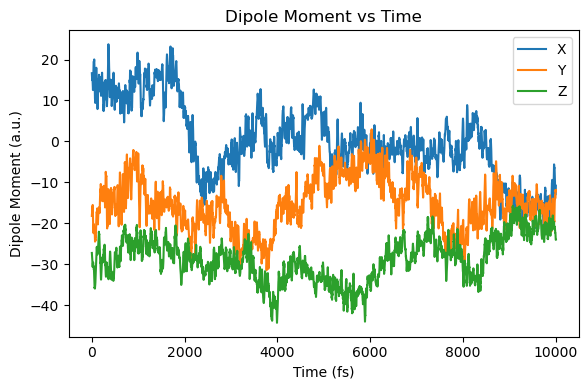

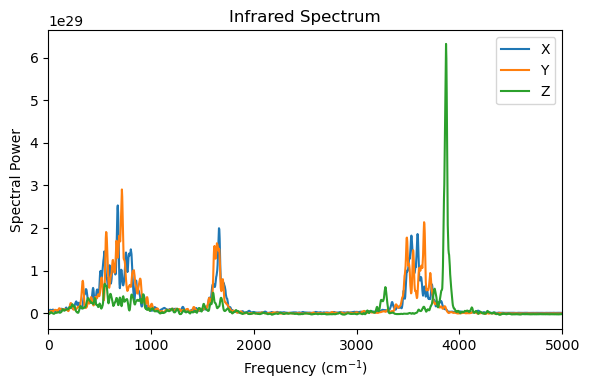

In [6]:
from maxwelllink.tools import ir_spectrum
import matplotlib.pyplot as plt

fs_to_au = 1 / 0.02418884254

mux = np.array([ad["mux_au"] for ad in molecule.additional_data_history])
muy = np.array([ad["muy_au"] for ad in molecule.additional_data_history])
muz = np.array([ad["muz_au"] for ad in molecule.additional_data_history])
t = np.array([ad["time_au"] for ad in molecule.additional_data_history]) / fs_to_au

plt.figure(figsize=(6, 4))
plt.plot(t, mux, label="X")
plt.plot(t, muy, label="Y")
plt.plot(t, muz, label="Z")
plt.xlabel("Time (fs)")
plt.ylabel("Dipole Moment (a.u.)")
plt.title("Dipole Moment vs Time")
plt.legend()
plt.tight_layout()
plt.show()

freq, sp_x = ir_spectrum(mux, 0.5*time_units_fs/resolution, field_description="square")
freq, sp_y = ir_spectrum(muy, 0.5*time_units_fs/resolution, field_description="square")
freq, sp_z = ir_spectrum(muz, 0.5*time_units_fs/resolution, field_description="square")

plt.figure(figsize=(6, 4))
plt.plot(freq, sp_x, label="X")
plt.plot(freq, sp_y, label="Y")
plt.plot(freq, sp_z, label="Z")
plt.xlim(0, 5000)
plt.xlabel("Frequency (cm$^{-1}$)")
plt.ylabel("Spectral Power")
plt.title("Infrared Spectrum")
plt.legend()
plt.tight_layout()

plt.show()



cell length in 1D is  9.164999999999997  mu


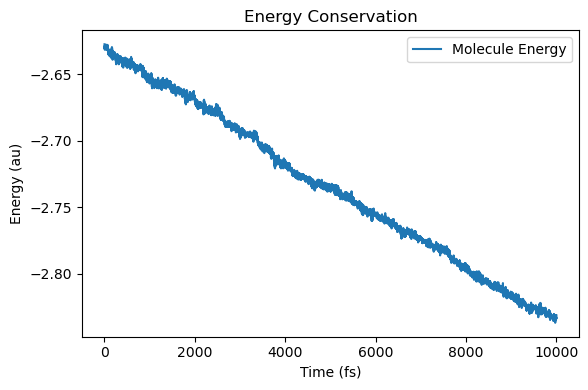

In [5]:
# also plot energy conservation dynamics
energy_molecule = np.array([ad["energy_au"] for ad in molecule.additional_data_history])

plt.figure(figsize=(6, 4))
plt.plot(t, energy_molecule, label="Molecule Energy")
plt.xlabel("Time (fs)")
plt.ylabel("Energy (au)")
plt.title("Energy Conservation")
plt.legend()
plt.tight_layout()

print("cell length in 1D is ", length, " mu")